In [ ]:
# --- Imports --- 
from IPython.display import Image
from IPython.core.display import HTML
import sys #rm
import os

from brian2 import *
from brian2tools import *
import brian2.numpy_ as np

import matplotlib.pyplot as plt
import random as r # try rm

get_ipython().run_line_magic('matplotlib', 'inline')
Jack=True

In [2]:
# --- Helper functions --- 

def input_wrap(inpt):
    '''Wraps built-in input() function to fix conflict with brian2's
    input() function. inpt: type(str)'''
    u_in = __builtins__.input(inpt)
    return u_in

def check_directory(first_run = True, path_valid = True, feed_path=False,verbose=True):
    '''Displays current working directory and gives option to change it
    printing verbose option currently rather makeshift, allows
    for quiet failure in case of path error with verbose=False
    '''
    ans = 'y' if feed_path else input_wrap(f"you are currently in \"{os.getcwd()}\" : Would you like to change directories?\n [y/n]\n") if first_run else (input_wrap("Please enter y or n") if path_valid else input_wrap("Would you like to re-enter a path? [y/n]")) 
    if ans == 'y':
        dir_path = feed_path if feed_path else input_wrap("please enter the comma-separated path to the target directory (eg. <c:\ or . >,model_folder,fig_1)")
        try:
            for i in dir_path.split(","):
                os.chdir(i)
            print(f"Switched to {os.getcwd()}") if verbose else None
        except:
            print(f"Error at \"{i}\": please check that the path exists") if verbose else None
            check_directory(first_run = False, path_valid = False) if verbose else None

    elif ans == 'n':
        print(f"Remaining in {os.getcwd()}") if verbose else None
        pass
    else:
        check_directory(first_run = False) if verbose else None
    return

def visualize_connectivity(S):
    '''Allows for visualization of connectivity between neurons or sets of neurons'''
    Ns = len(S.source)
    Nt = len(S.target)
    plt.figure(figsize=(10,4))
    plt.subplot(121)  
    plt.plot(zeros(Ns), np.arange(Ns), 'ow', ms=10)
    plt.plot(ones(Nt), np.arange(Nt), 'ow',ms=10)
    for i,j in zip(S.i, S.j):
        plt.plot([0,1], [i,j], '-w')
    plt.xticks([0,1], ['Source', 'Target'])
    plt.ylabel('Neuron Index')
    plt.xlim(-0.1,1.1)
    plt.ylim(-1,max(Ns,Nt))
    plt.subplot(122),
    plt.plot(S.i,S.j,'ow')
    plt.xlim(-1,Ns)
    plt.ylim(-1,Nt)
    plt.xlabel("Source Neuron Index")
    plt.ylabel("Target Neuron Index")
    return

def get_user_input(get_input=True,dict_of_inputs=None):
    if get_input:
            if input_wrap("Would you like to edit sim parameters?[y/n]\n") == 'y':
                if not dict_of_inputs:
                    print("Please pass the function a dictionary of input names")
                    return
                
                inps = { i[0] : i[1] for i in list(map(lambda x: x.split(":"),input_wrap(f"""
                current sim parameters: {[(f"{key} : {test_dict[key]}") for key in dict_of_inputs]}\n
                Please enter any parameters you wish to change as sets of <name><colon><value> separated by <comma> e.g: n_neurons:5,R:20*Mohm
                """).split(",")))}
                for key, val in inps.items():
                    try:
                        dict_of_inputs.update({key : val})
                        exec(f"{key} = {val}")
                    except:
                        print(f"error during entry with {k}")
                        pass
            else:
                pass
    return #dict_of_inputs

In [3]:
def plot_many(func_n_neurons=None,func_runtime=None, func_G=None,func_statemon=None,
              func_spikemon=None,func_thresh=None, choose_plot='aggregate',
              rasters=False,ifcurve=False,single_traces=True, inputcurrent=False,
              plot_colors=True,plot_spikes=True,**HH_scale):
    '''would absolutely be good to add a docstring here
    add random sampling for the display of 10 plots when func_n_neurons >10 instead of only first 10 or specified indices
    inputcurrent takes true or false and assumes that the state variable for current is named I'''
    
    show_I = (lambda indx: round(float(np.asarray(func_G.I[indx]/nA)),2))
    
    for idx,nrn in enumerate(range(func_n_neurons)):
    ## random linecolors if desired
        if plot_colors:
            color_frac = 1 / len(range(func_n_neurons)) * idx
            rgb1 = 1 - color_frac ; rgb2 = uniform() ; rgb3 = color_frac
            order1 = [rgb1,rgb2,rgb3]; order2=[rgb3,rgb1,rgb2]; order3=[rgb2,rgb3,rgb1]
            chance = uniform()
            line_color = order1 if uniform() < (1/3) else (order2 if uniform() < (2/3) else order3)
            for idx2,rgb in enumerate(line_color):
                line_color[idx2] = rgb * uniform(low=0.1,high=0.9) if rgb > 0.7 else rgb
        else:
            line_color = 'black'
    
    


    if choose_plot == 'individual':

        fontsize = 12
        ls_len = func_n_neurons if func_n_neurons < 10 else 10
        neurons_to_check = [i for i in range(ls_len)]
        fig = plt.figure(figsize=(15,10),constrained_layout=False)
        gs = fig.add_gridspec(ls_len,4)
        print(gs,"gs")
        gs.update(wspace=0.5,hspace=0.1)

        ## plotting overlayed [overlayed] and individual [single] traces
        #dividing plot space
        if rasters:
            overlayed = fig.add_subplot(gs[:int(ls_len/2),:-2])
        else:
            overlayed = fig.add_subplot(gs[:,:-2])
            
        HH_width_adjust = 0.3 if HH_scale else 1
    #ooverlayed.plot(func_statemon.t/ms, func_statemon.v[nrn]/mV, linewidth=0.5, label=f"neuron {nrn}")
        
        for idx,nrn in enumerate(range(func_n_neurons)):
            nrn_color = [uniform(0,0.7),uniform(0,0.7),uniform(0,0.7)]

            if idx < 10:
                if single_traces:
                    single = fig.add_subplot(gs[idx,3])
                    glist = [single]
                    single.plot(func_statemon.t/ms,func_statemon.v[nrn]/mV, color=nrn_color if plot_colors else 'black', linewidth=round((1 * HH_width_adjust),2), label=f" neuron {nrn}: Input {show_I(idx)}nA")

                    if inputcurrent:
                        current = fig.add_subplot(gs[idx,2])
                        glist.append(current)
                        current.plot(func_statemon.t/ms,func_statemon.I[nrn]/mV, color=nrn_color if plot_colors else 'black', linewidth=round((1 * HH_width_adjust),2))

                
                    for graph in glist:
                        if idx == 0:
                            graph.set_title("Individual voltage traces",pad=0)
                            graph.set_title("Individual input currents",pad=0)
                        graph.xaxis.set_visible(False)
                        graph.set_xticks([0])
                        graph.yaxis.set_visible(False)
                        graph.spines['top'].set_visible(False)
                        graph.spines['right'].set_visible(False)
                        graph.set_xbound(lower= func_runtime/ms-300 if func_runtime/ms >=300 else 0, upper=func_runtime/ms)
                    single.set_ylim(bottom=-75,top=45)
                    single.legend(frameon=False,loc='right',bbox_to_anchor=(1.8,0.4),handlelength = 0)
            
            overlayed.plot(func_statemon.t/ms, func_statemon.v[nrn]/mV, linewidth=0.5, label=f"neuron {nrn}")

        ## Formatting overlayed traces
        overlayed.set_title(f"Whole group spike output")
        overlayed.set_xlabel('time (ms)')
        overlayed.set_ylabel('Vm (mV)')
        overlayed.set_ybound(upper=-35)
        overlayed.spines['top'].set_visible(False)
        overlayed.spines['right'].set_visible(False)

        if ifcurve:
            ## plotting and formatting I-F curve
            I_F = fig.add_subplot(gs[int(ls_len/2 + 1):,0])
            I_F.plot(func_G.v/nA, func_spikemon.count/func_runtime, color = [uniform(),uniform(),uniform()] if plot_colors else 'black') 
            # dividing HH.I by the units removes them, allowing for easy plotting
            # dividing # of spikes by the func_runtime gives the firing rate
            I_F.set_title('Input - Frequency Curve')
            I_F.set_xlabel(' Input Current (nA)')
            I_F.set_ylabel('Firing Rate (Hz)')
            I_F.spines['top'].set_visible(False)
            I_F.spines['right'].set_visible(False)

        if rasters:
            ##--- plotting raster
            if ifcurve:
                raster = fig.add_subplot(gs[int(ls_len/2 + 1):,1])
            else:
                raster = fig.add_subplot(gs[int(ls_len/2 + 1):,:-2])
                raster.plot(func_spikemon.t/ms,func_spikemon.i, '.', color = [uniform(),uniform(),uniform()] if plot_colors else 'black')
                raster.set_title('Spike Raster',pad=0)
                raster.set_xlabel(f"spike times (ms)")
                raster.set_ylabel('neuron index')
                raster.spines['top'].set_visible(False)
                raster.spines['right'].set_visible(False)
            
    elif choose_plot == 'aggregate':     # ----- plotting
        fig = plt.figure(figsize=(15,10),constrained_layout=False)
        plt.gcf().set_size_inches(std_panelsize[0]*2.4,std_panelsize[1]*2) # formatting maybe extra
        gs = fig.add_gridspec(2,4)
        gs.update(wspace=0.5,hspace=0.1)
        f1 = 16
        f2 = 24
        
        traces = fig.add_subplot(gs[0,:])
        if inputcurrent:
            current = fig.add_subplot(gs[1,:2])
            raster = fig.add_subplot(gs[1,2:])
            figlist = [traces,current,raster]
        else:
            raster = fig.add_subplot(gs[1,:])
            figlist = [traces,raster]
        if not plot_colors:
            print("The aggregate plot is easier to view when plot_colors=True")
        
            
        plt.xlabel("time(ms)",fontsize=18)
        if HH_scale:
            traces.set_ylim(-90,60)
        else:
            traces.set_ylim(-66,-25)
        
        #--- add spikes to IF plots
        if plot_spikes and not HH_scale:
            sp = (lambda axn,t,lc: axn.axvline(t/ms,ls='-', c=lc,lw=0.5))
        else:
            sp = (lambda axn,t,lc: False)
        for t in func_spikemon.t:
            sp(traces,t,'0.35')
            
        for idx in range(func_n_neurons):
            nrn_color = [uniform(0,0.7),uniform(0,0.7),uniform(0,0.7)]
            if idx < 10:
                traces.plot(func_statemon.t/ms, func_statemon.v[idx]/mV,color = nrn_color if plot_colors else 'black', label=(f"neuron {idx}: Input {show_I(idx)} nA" if idx < 11 else None))
                if inputcurrent:
                    current.plot(func_statemon.t/ms,func_statemon.I[idx]/nA,color=nrn_color if plot_colors else 'black')
        
        raster.plot(func_spikemon.t/ms,func_spikemon.i,'.k', linewidth=5,color = 'black' if plot_colors else 'black'); raster.set_ylabel("Neuron index",fontsize=18)
        raster.set_yticks([i for i in range(func_n_neurons)])
        
        traces.legend(frameon=False,loc='right',bbox_to_anchor=(1.29,0.5),handlelength = 0.5,fontsize=f1) ; traces.set_ylabel("voltage (mV)",fontsize=f1)
        traces.set_title("Voltage traces and spike rasters from Integrate and Fire neurons", fontsize=f2, pad=10)

        
        for idx in figlist:
            idx.set_xlim(0,runtime/ms)

    else:
        print('please enter either "individual" or "aggregate" for choose_plot')
    return

std_panelsize = [6,4]
save_figs = True

# **Brian 2**
---  

1. [**What it is**](#whatis)

2. [**Installation**](#installation)
    * [Importing brian2](#importing)  
        

3. [**Brian2 Basics**](#brian2basics)
    * [Units](#units)
    * [Key components of brian2 code](#keyparts)
    * [Example: Input-Frequency curves with noise](#basicexample)  
    
    
4. [**Spiking Neuron Models in Brian2**](#spikemodels)
    * [Neurobiology of Common Model Parameters](#neurobio)
    * [Models in Brian2 are defined by differential equations](#diffeqs)
    * [Differential equations are passed in as strings](#eqstrings)
    * [Example: IF versus HH activity](#randomif)
    
5. [**Literature Examples**](#lit)
    * [Spatial Representation](#space)
    * [Modelling smooth pursuit eye movements](#eyexample)

6. [**Strengths and Weaknesses**](#strengths)
6. [**Resources**](#resources)
7. [**references**](#references)

<br><br><br>

<a id="whatis"></a>
## **What it is**
---   


- **Python package for simulating biologically detailed networks of spiking neurons**

- **Can simulate neuronal activity at multiple scales:**
    * Dynamics between multiple interconnected populations
    * Population-level activity 
    * Detailed activity of small networks
    * Spatially accurate biophysical characteristics of individual neurons  
      
      
- **Flexible -** the level of detail used can be adapted to the needs of the experiment and the researcher.


<br>

 <a id="installation"></a>
 ## **Installation**
---
Brian2 is [simple to install](https://brian2.readthedocs.io/en/stable/introduction/install.html)
  
  
##### With conda:

 ```
 conda create -n <your_env>
 activate <your_env>
 conda install -c conda-forge brian2
 conda install matplotlib nose ipython jupyter
 ```
 
The `brian2tools` package provides some additional functions for graphing collected data and neuron morphologies
```
conda install -c brian_team brian2tools
```

<a id="importing"></a>
#### Importing brian2
---
brian2 works best when the whole module is imported into the namespace. This import includes matplotlib and numpy functions configured to work with brian2's unit system.

```python
from brian2 import *```
to prefix numpy and matplotlib functions while keeping their brian2 versions intact, use the import structure below
```python
from brian2 import *
import brian2.numpy_ as np
import matplotlib.pyplot as plt
```

##### **Note :**
the full `brian2` import brings a function named `input` that interferes with the built-in python function of the same name. The function below can be used to accept user input without interfering with brian2

```python
def input_wrap(inpt):
    '''Wraps built-in input() function to fix name conflict with brian2's
    input() function. inpt: type(str)'''
    user_in = __builtins__.input(inpt)
    return u_in
```
<br><br><br>

<a id="brian2basics"></a>
## **Brian2 Basics**
---

<a id="units"></a>
#### **Units**
---
Brian2 uses the SI unit system, and calculations return dimensionally consistent results. For example in Ohm's law $V = IR$ , $I$ has units of amps and $R$ has units of Ohms  

With brian2's unit system, this would be written as:
```python
I = 2*amp
R = 550*ohm
V = I * R
```  

When evaluated, the voltage is returned with the correct unit and scale


In [5]:
I_ex = 2*amp
R_ex = 550*ohm
V_ex = I_ex * R_ex
print(V_ex)

1.1 kV


<a id="keyparts"></a>

#### **Key components of brian2 code**
---  
The following elements form the base of most code written for brian2 simulations. 
<br>  


**Equations :**
```python
eqs = Equations('''
dv/dt = (I - v)/tau : 1 <any flags>
I : <unit I>
tau : <unit tau>
''')```
* define the activity of models with differential equations, and the state variables within models 
* pass to the `model=` parameter of NeuronGroup and Synapses objects  

<br>  
**NeuronGroup :**
```python
G = NeuronGroup(N=10,model=eqs,threshold='v>0.9',reset='v=0',refractory=3*ms,method='euler')
```
* creates a population of `N` neurons that use the same `model` equations 
* define spiking behavior for that population; `method='euler'` defines the type of [numerical integration](https://brian2.readthedocs.io/en/stable/user/numerical_integration.html) to use
* **Note -** object variables can be accessed without their associated units by adding an underscore to the end, e.g. "`G.v_`"
 
<br>  

**Synapses :**
```python
S = Synapses(G, G1, model=''' 
w : 1
p : 1''', on_pre='v_post += w * (rand()<p)', on_post=None)

S.w = 0.4
S.p = 0.8

```
* define dynamics of synaptic variables and connections between neurons in the presynaptic (`G`) and postsynaptic (`G1`) NeuronGroups
    * here, synaptic weight `S.w` and the chance it will be applied `S.p` are respectively set at 0.4 and 0.8 for the whole synapse
  
  
* `on_pre` and `on_post` define what happens when pre and postsynaptic spikes fire  


* synaptic connections can be instantiated by index
    * `S.connect(i=1, j=4)` connects presynaptic neuron 1 to postsynaptic neuron 4
  
  
* or probability
    * `S.connect(p=0.5)` has a 50% chance of connecting any two neurons
    * `S.connect(p='abs(i-j) /(1.0*n_neurons)')` yields probability from an equation
  
  
* or condition
    * `S.connect(condition='abs(i-j)>2 and abs(i-j) < 5')` only connects neurons within certain indices of eachother

<br>  

**StateMonitor :**
```python
state_mon = StateMonitor(source=G, variables='v', record=range(10)
```
* records values of the state variables in `variables` from the indices of object `source` specified in `record` for NeuronGroups and Synapses
  
<br>  

**SpikeMonitor :**
```python
spike_mon = SpikeMonitor(source=G, record=True)
```
* records the spike times from the indices of object `source` (typically a NeuronGroup) specified in `record`
* here, `record=True` means that spike times will be recorded from all indices in `G`
 
<br>  

**Commands :**
`start_scope()` and `run()`
```python
start_scope()
```
* stops objects preceding the call from being included in the next `run` 


```python
run(300*ms)
```
* runs the simulation for the specified length of time  
<br>  

**Network Operations**
```python
@network_operation(dt=10*ms)

def reset_v_every_dt():
    '''set each neuron in G's voltage to 0 after each timstep'''
    for idx in range(n_neurons):
        G.v[idx] = 0
```
* allows user-written python code to be executed at every dt in the run
* great for defining functions that wouldn't otherwise fit well in brian2

<br><br><br>

<a id="basicexample"></a>
## **Examples**
---

#### **Input-Frequency curves with noise**
* Input-Frequency curves describe the relationship between the input stimulus a neuron receives and its firing rate
* biological systems are noisy - brian2 has a built-in variable `xi` (drawn from $X \sim N(0,1)$) to introduce noise into a system
* The neurons in each group below receive an input current that scales with their index


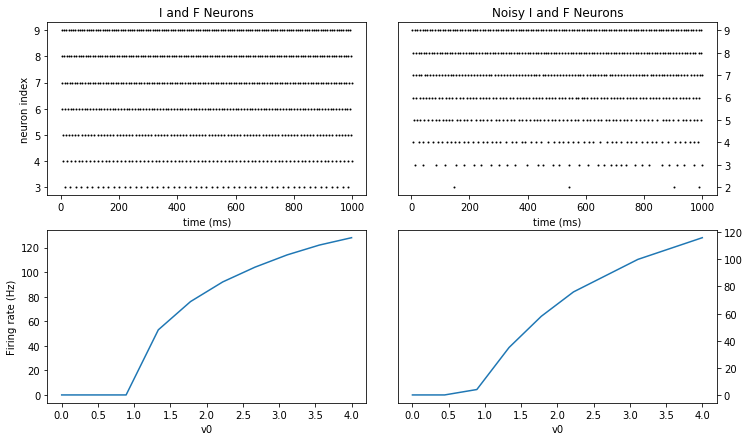

In [6]:
start_scope()

n_neurons = 10
tau_base = 10*ms
v0_max = 4.
runtime = 1000*ms
sigma = 0.2

## --- without noise
eqs = Equations('''
dv/dt = (v0-v)/tau : 1 (unless refractory)
v0 : 1
tau : second
''')
G = NeuronGroup(n_neurons, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='euler')
spikemon = SpikeMonitor(G)
G.v0 = 'i*v0_max/(N-1)'
G.tau= tau_base

## --- with noise
eqs_noisy = Equations('''
dv/dt = (v0-v)/tau+sigma*xi*tau**-0.5 : 1 (unless refractory)
v0 : 1
tau : second
''')
G_noisy = NeuronGroup(n_neurons, eqs_noisy, threshold='v>1', reset='v=0', refractory=5*ms, method='euler')
spikemon_noisy = SpikeMonitor(G_noisy)
G_noisy.v0 = 'i*v0_max*0.8/(N-1)'
G_noisy.tau = tau_base
run(runtime)

## --- plotting
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(12,7))
plt.subplots_adjust(wspace=0.1,hspace=0.2)
## -raster
axes[0,0].plot(spikemon.t/ms, spikemon.i, '.k',markersize=2)
axes[0,1].plot(spikemon_noisy.t/ms, spikemon_noisy.i, '.k',markersize=2,markeredgecolor='black')
## - input-freq
axes[1,1].plot(G.v0,spikemon_noisy.count/runtime)
axes[1,0].plot(G.v0,spikemon.count/runtime)

axes[0,0].set_title("I and F Neurons")
axes[0,1].set_title("Noisy I and F Neurons")
axes[0,0].set_ylabel("neuron index")
axes[1,0].set_ylabel("Firing rate (Hz)")
for idx in range(2):
    #axes[0,idx].spines['bottom'].set_visible(False)
    #axes[1,idx].spines['top'].set_visible(False)
    #axes[0,idx].xaxis.set_ticks([])
    axes[0,idx].set_xlabel('time (ms)')
    axes[1,idx].set_xlabel('v0')
    axes[idx,1].yaxis.tick_right()
    axes[idx,1].yaxis.set_label_position("right")


In [7]:
# #### **Recording spikes and voltage in brian2**
# ---
# * brian2 is able to record 
# * Adjust the parameters below to see their effect on the firing of this population of Integrate and Fire neurons
# ##----- top level control
# user_input = False
# plot_choice = 'aggregate'  # either 'aggregate' or 'individual'
# current_choice = 'random' # 'random' or 'scaling'
# # ##-----simulation setup -----
# # plt.cla()
# # plt.clf()
# # I = None

# # start_scope()

# # runtime = 100*ms
# # n_neurons = 10
# # thresh_mv = -40
# # vrest_mv = -65
# # refract_ms = 3
# # tau_base = 10*ms
# # I_in = 1*nA
# # R = 3*Mohm

# # I_str_scaling = 'I_in * i'
# # I_str_rand = 'I_in / (0.05)**rand()'
# # I_str = I_str_rand if current_choice == 'random' else I_str_scaling

# # eqs = Equations('''
# # dv/dt = (-v + R * I)/tau : volt (unless refractory)
# # I : amp
# # tau : second
# # ''')





# # ##----- get user input ----- not inside a function due to a namespace issue - why no longer showing with units
# # if user_input == True:
# #         if input_wrap("Would you like to edit sim parameters?[y/n]\n") == 'y':
# #             params=["user_input","plot_choice","I_str","n_neurons","thresh_mv","vrest_mv","refract_ms","tau_base","I_in","R","runtime"]
# #             print("current parameters:")
# #             for i in params:
# #                 print(f"{i}={eval(i)}")
# #             inps = list(map(lambda x: x.split(":"), input_wrap(f"""
# #             Please enter any parameters you wish to change as <name><colon><value> separated by commas. e.g: n_neurons:5,R:20*Mohm
# #             """).split(", ")))
# #             for idx,k in enumerate(inps):
# #                 if k != " ":
# #                     try:
# #                         exec(f"{k[0]} = {k[1]}")
# #                         print(f"{k[0]} = {k[1]}")
# #                     except:
# #                         print(f"error during entry with {k}")
# #                         pass


# # ##-----initialize state variables and monitors, run sim -----
# # G = NeuronGroup(n_neurons,model=eqs, threshold = f"v>{thresh_mv}*mV", reset = f'v={vrest_mv}*mV', refractory=refract_ms*ms, method = 'euler')
# # G.I=str(I_str)
# # G.tau = tau_base
# # statemon = StateMonitor(G, ['v','I'], record=True)
# # spikemon = SpikeMonitor(G, record=True)
# # run(runtime)

# # I_str_scaling = 'I_in * i'
# # I_str_rand = 'I_in / (0.05)**rand()'
# # I_str = I_str_rand if current_choice == 'random' else I_str_scaling

# # eqs = Equations('''
# # dv/dt = (-v + R * I)/tau : volt (unless refractory)
# # I : amp
# # tau : second
# # ''')


# # ##----- plotting function

# # plot_many(choose_plot=plot_choice, plot_colors=True, plot_spikes=True, rasters=True, ifcurve=False, single_traces=True, 
          
# #           func_n_neurons=n_neurons, func_runtime=runtime, func_G=G, func_statemon=statemon, func_spikemon=spikemon)

<a id="spikemodels"></a>
# **Spiking Neuron Models in Brian2**


<a id="neurobio"></a>
<br>

### Neurobiology of Common Model Parameters
---

* Neurons spike when their membrane voltage **($v$)** changes enough to reach a certain threshold

* This change in voltage represents the build-up of opposite electrical charges on the interior and exterior of the membrane; these charges are carried by ionic currents ($I$) flowing through open ion channels in the membrane.
    
* Current flow across a membrane depends on how many ion channels are present in that membrane, and how many of those channels are open for current to pass through. The obstruction to current flow caused by these characteristics is quantified in the membrane Resistance $R$ (or $R_M$)

* When current stops flowing across a membrane, built-up charges will dissipate over time and the membrane voltage will return to $v_{rest}$. The rate at which the membrane charges and discharges is captured in time constant *tau* **($\tau$)**

<a id="diffeqs"></a>
### Models in Brian2 are defined by differential equations
---
Brian2 can implement models that span a wide range of biological complexity. Though increased realism is preferable in many experiments, more realistic models take more processing power to run and can become impractical for large simulations.  Leaky Integrate and Fire (LIF) is a model that trades some biological  for the ability to run at much larger scales whereas Hodgkin - Huxley (HH) models make the opposite trade.
<br></br>
**Leaky Integrate and Fire** 
<br></br>

$$\frac{dv}{dt} = \frac{v_{rest} -v(t) + RI(t)}{\tau}$$
<br>

 * simple 
 * concerned only with spiking - good for simulating large populations
 * neuron spikes when membrane voltage ($v$) reaches a predefined threshold, and $v$ resets
 * computationally light
 * can be simplified further:  $$\frac{dv}{dt} = \frac{1-v(t)}{\tau}$$

 <br></br>
**Hodgkin - Huxley Model**
<br></br>

 $$\frac{dv}{dt} = \frac{I_{L} + I_{K} + I_{Na}}{C_{m}}$$
 *  complex
 * accounts for factors like neuron size, ionic conductance, driving force, channel state, etc. 
 * computationally heavy -  $I_{L}$,  $I_{Na}$, $I_{K}$, and the variables $m$, $n$, and $h$ each have their own equation
 
     - Leak Current $I_L$: $$ I_{L} = g_{L} (E_{L} - v)$$
 
     - Sodium Current $I_{Na}$: $$ I_{Na} = g_{na} m^{3} h (v - E_{Na}) $$
 
     - Potassium Current $I_K$: $$ I_{K} = g_{K} n^{4} (v - E_{K}) $$


        Expanded HH equation:

$$\frac{dv}{dt} = g_{L} (E_{L} - v) - g_{na} m^{3} h (v - E_{Na}) - g_{K} n^{4} (v - E_{K}) + I) C_{m}^{-1} $$  





<a id="eqstrings"></a>
#### Differential equations are passed in as strings
---
The equations that define model activity are passed as multi-line strings to `Equations` objects, and each line is separated into two sides by a colon `:`. The left side defines how the parameters in that line evolve over time, and the right side defines their units and any conditions for the parameters to follow

**Leaky Integrate and Fire**

```python
eqs_lif_simple = Equations('''
dv/dt = (1-v)/tau : 1 (unless refractory)
''')

eqs_lif = Equations('''
dv/dt = (-v + R * I)/tau : volt (unless refractory)
I : amp
tau : second
''')
```

In [8]:
eqs_lif_simple = Equations('''
dv/dt = (1-v)/tau : 1 (unless refractory)
''')

eqs_lif = Equations('''
dv/dt = (-v + R * I)/tau : volt (unless refractory)
I : amp
tau : second
''')


* one differential equation defines the model
* in the simplification, ` : 1` indicates that the $v$ variable is unitless and $\tau$ denotes an external variable

* in the complex version, `volt` indicates that $v$ is now defined with units, `I : amp` defines an state variable `I` with the unit amps, and`tau : second` defines a state variable $\tau$ with the unit s  
    
 * `(unless refractory)` specifies a condition in which the model will not follow the equation while in an externally defined refractory state.  
      

**Hodgkin - Huxley**

```python
eqs_HH = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
(exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
(exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
(exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
tau : second
''')
```

In [9]:
eqs_HH = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
(exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
(exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
(exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
tau : second
''')

* The equations required to define the Hodgkin - Huxley model are more involved and require additional variables like El to be defined outside the string
* Equations for the evolution of $m$, $n$, $h$, are defined on their own individual lines


<a id="randomif"></a>
#### **Example: Integrate and Fire neurons driven by semi- random step protocol**
---  

The parameters in the examples below can be adjusted to see their effects on spiking activity

GridSpec(6, 4) gs


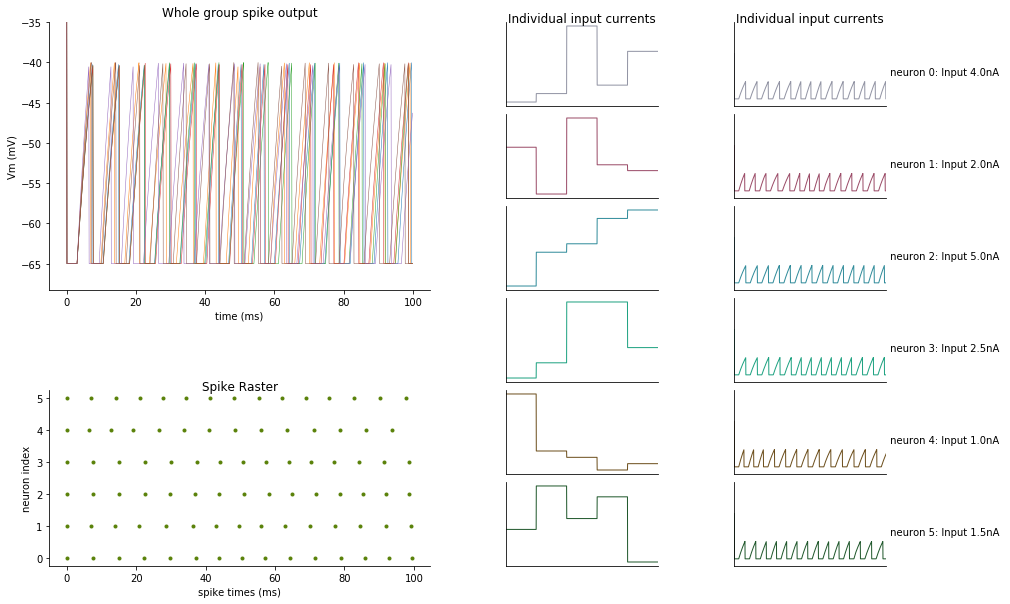

In [10]:
# non simple I and F
start_scope()

n_neurons = 6
runtime = 100*ms
thresh_mv = -40
vrest_mv = -65
refract_ms = 3
tau_base = 10*ms
I_in = 1*nA
R = 3*Mohm

G = NeuronGroup(n_neurons,model=eqs_lif, threshold = f"v>{thresh_mv}*mV", reset = f'v={vrest_mv}*mV', refractory=refract_ms*ms, method = 'euler')
G.I=I_in
G.tau = tau_base
# statemon = StateMonitor(G, ['v','I'], record=True)
# spikemon = SpikeMonitor(G, record=True)

# G = NeuronGroup(n_neurons,model=eqs, threshold = f"v>{thresh}*mV", reset = f'v={vrest}*mV', refractory=refract_ms*ms, method = 'euler')
# I_in = 15*nA

# @network_operation(dt=runtime * 0.25)
# def current_switch():
#     I_ins = [0.1 * (abs(5 - x) * 5) for x in range(20)]
#     for idx in range(n_neurons):
#         G.I[idx] = I_ins[randint(0,len(I_ins)-1)]*nA

rateswitch = 0.2
@network_operation(dt=runtime * rateswitch)
def current_switch():
    I_ins = [0.1 * (abs(5 - x) * 5) for x in range(20)]
    for idx in range(n_neurons):
        G.I[idx] = I_ins[randint(0,len(I_ins)-1)]*nA

statemon = StateMonitor(G, ['v','I'], record=True)
spikemon = SpikeMonitor(G, record=True)
run(runtime)


plot_many(choose_plot='individual', plot_colors=True, plot_spikes=True,
          rasters=True, ifcurve=False, single_traces=True,inputcurrent=True,
          func_n_neurons=n_neurons, func_runtime=runtime, func_G=G,
          func_statemon=statemon, func_spikemon=spikemon)



fig.savefig('ExPanel1.png') if save_figs else None

#### **Example: Hodgkin-Huxley Neurons driven by semi-random step protocol**
---  
As above, the parameters in the examples below can be adjusted - Hodgkin - Huxley models can model conditions in much more detail thanks to their level of realism. Toxins and disease states can affect very specific parameters - [Tetrodotoxin](https://en.wikipedia.org/wiki/Tetrodotoxin) from pufferfish, for example, would reduce the value of gNa

<a id="voltagecode"></a>

GridSpec(5, 4) gs


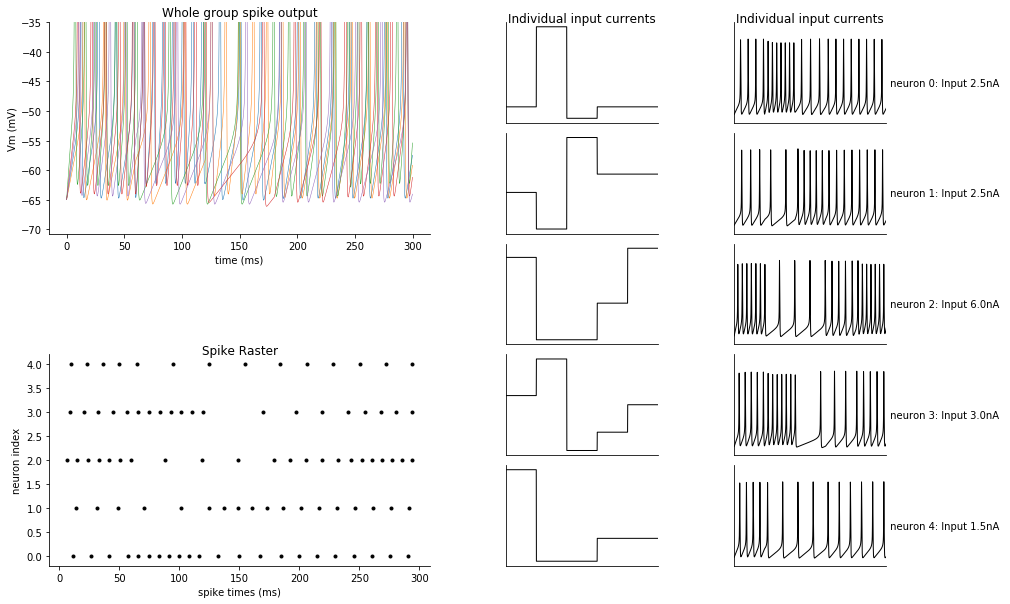

In [11]:
start_scope()

n_neurons = 5
runtime = 300*ms


# HH parameters
area = 20000*umetre**2
Cm = 10*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV


HH = NeuronGroup(n_neurons, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')


rateswitch = 0.2
@network_operation(dt=runtime * rateswitch)
def current_switch():
    I_ins = [0.1 * (abs(5 - x) * 5) for x in range(20)]
    for idx in range(n_neurons):
        HH.I[idx] = I_ins[randint(0,len(I_ins)-1)]*nA

I_in = 0.7*nA

HH.v = El
HH.I = I_in
statemon = StateMonitor(HH,['v','I'], record=True)
spikemon = SpikeMonitor(HH, record = True)
run(runtime)

plot_many(choose_plot='individual', plot_colors=False, plot_spikes=True,
          rasters=True, ifcurve=False, single_traces=True,inputcurrent=True,
          func_n_neurons=n_neurons, func_runtime=runtime, func_G=HH,
          func_statemon=statemon, func_spikemon=spikemon)

# for idx in range(n_neurons):
#     plt.plot(statemon.t/ms,statemon.I[idx])

<a id="space"></a>
## **Spatial Representation in Brian2**
---

In [ ]:
## -- loading images
if Jack == True:
    imgdir = "c:\\git\\brian\\Bono_Clopath_2017\\images\\brianshow\\"
    modeldir = "c:\\git\\brian\\Bono_Clopath_2017\\0. Model\\"
    check_directory(feed_path="c:\,git,brian",verbose=True)
    

* brian2 can simulate spatially accurate neuronal activity with comparable detail to NEURON. Bono and Clopath (2017) used brian2 to evaluate mechanisms of synaptic plasticity at different locations along the basal dendrites of detailed neuron models
    * A comparison between NEURON and brian2 is available in [Resources](#comparison)
    * Bono & Clopath (2017) is available in [References](#bono).

(-235.32676538123317, 308.9001608273013, -234.6478762380449, 514.9256104152932)

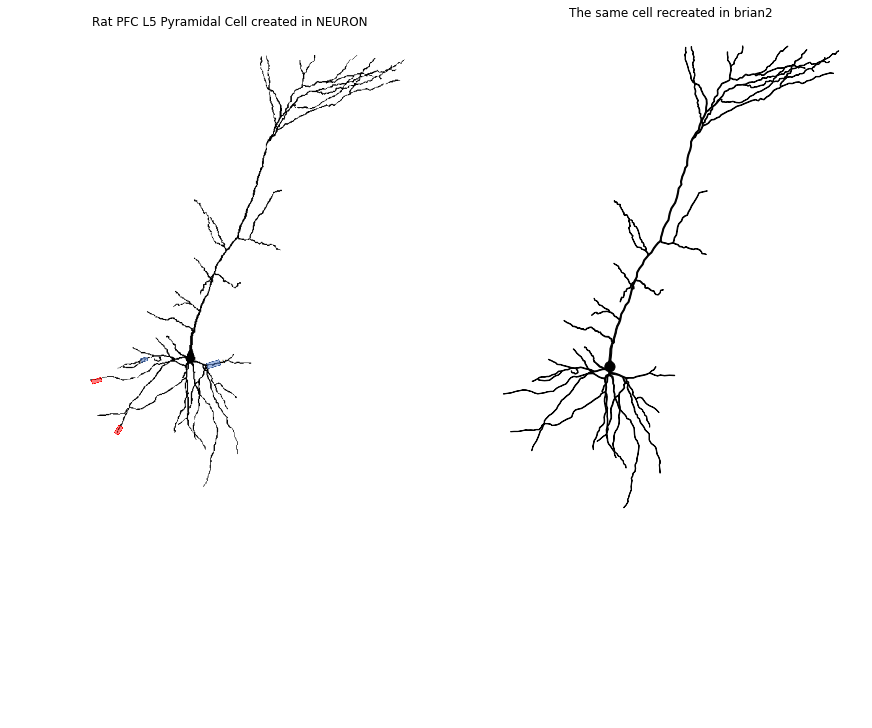

In [13]:
morph_acker = Morphology.from_file(modeldir+'Acker2008.swc')
f1a = plt.imread(imgdir+'f1a.png')
f1b1 = plt.imread(imgdir+'Integr_dist_original.png')
f1b2 = plt.imread(imgdir+'Integr_prox.png')

fig = plt.figure(figsize=(12,10),constrained_layout=True)
gs = fig.add_gridspec(nrows=3,ncols=2)
ax0 = fig.add_subplot(gs[:2,:1])
#ax0.annotate("""Boxes:\nblue - distal region of basal dendrite\nred - proximal region of basal dendrite""",(950,1100))
ax0.imshow(f1a)#,mode='rb')
ax0.set_title('''Rat PFC L5 Pyramidal Cell created in NEURON''')
ax0.axis('off')
ax1 = fig.add_subplot(gs[:2,1:])
plot_morphology(morph_acker, plot_3d=False,show_diameter=True,axes=ax1,colors=('black',))
ax1.set_title('''The same cell recreated in brian2''')
ax1.axis('off')
# ax2 = fig.add_subplot(gs[2:,1:])
# plot_morphology(morph_branco, plot_3d=False,show_diameter=True,axes=ax1,colors=('black',))
# ax2.set_title('''Layer 2/3 Pyramidal Cell in brian2''')
# ax2.axis('off')

* **Left :** The shaded red and blue boxes represent proximal and distal locations on basal dendrites, respectively  

  **Right :** the `brian2tools` function `plot_morphology` allows the neuron's structure to be visualized

(-0.5, 1370.5, 758.5, -0.5)

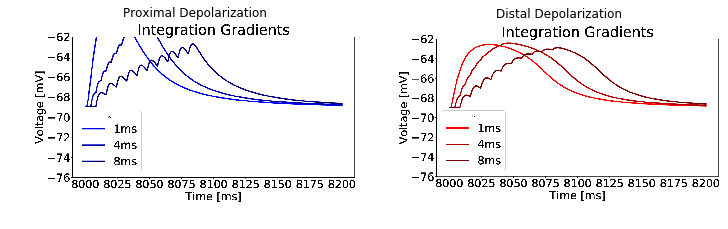

In [14]:
fig = plt.figure(figsize=(10,8),constrained_layout=True)
gs = fig.add_gridspec(nrows=1,ncols=2)
ax3 = fig.add_subplot(gs[0,:1])
ax3.imshow(f1b2)
ax3.set_title('Proximal Depolarization')
ax3.axis('off')

ax4 = fig.add_subplot(gs[0,1:])
ax4.imshow(f1b1)#,mode='rb'))
ax4.set_title('Distal Depolarization')
ax4.axis('off')

* code for this model can be found on [ModelDB](https://senselab.med.yale.edu/modeldb/showmodel.cshtml?model=232914#tabs-2)

<a id="eyexample"></a>
### **Example: Modelling eye movement during smooth pursuit** - Stimberg et al., 2019
---
<br>
  
* Because models in brian2 are based off of user-defined equations and variables, they can implement diverse phenomena. 
* Stimberg et al. show how brian2 can be used to model eye movements while following a target. Synapses in the code below are used to model the relationships between these groups of neurons

##### To create this figure, NeuronGroups were used to model:
* the position and movement of the eye itself : `eqs_eye` and the `eye` NeuronGroup
* motor neurons that control the activity of opposing extra-ocular muscles responsible for moving the eye : `motoneurons`, `motosynapses`,
* retinal neurons that feed visual information to the motor neurons : `retina`, `sensorimotor_synapses`



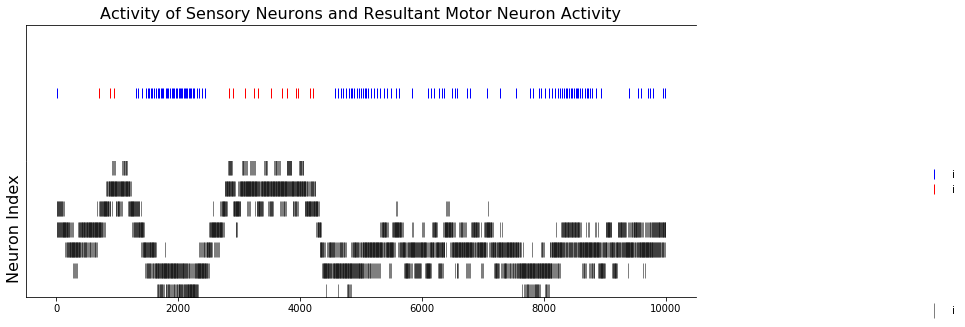

In [15]:
start_scope()
alpha = (1/(50*ms))**2; beta = 1/(50*ms); tau_muscle = 20*ms; tau_object = 500*ms 

eqs_eye = '''dx/dt = velocity : 1 
dvelocity/dt = alpha*(x0-x)-beta*velocity : 1/second 
dx0/dt = -x0/tau_muscle : 1 
dx_object/dt = (noise - x_object)/tau_object: 1 
dnoise/dt = -noise/tau_object + tau_object**-0.5*xi : 1''' 
eye = NeuronGroup(1, model=eqs_eye, method='euler')
eyemon = StateMonitor(eye,['x','velocity','x_object'],record=True)

taum = 20*ms 
motoneurons = NeuronGroup(2, model='dv/dt = -v/taum : 1', threshold='v>1', reset='v=0', 
refractory=5*ms, method='exact')

motosynapses = Synapses(motoneurons, eye, model='w : 1', on_pre='x0_post += w') 
motosynapses.connect() # connects all motoneurons to the eye 
motosynapses.w = [-0.5, 0.5]

motor = StateMonitor(motoneurons,['v'],record=True)
motorspike1 = SpikeMonitor(motoneurons[:1],record=True)
motorspike2 = SpikeMonitor(motoneurons[1:],record=True)

N = 20; width = 2./N; gain = 4.
eqs_retina = '''dv/dt = (I-(1+gs)*v)/taum : 1 
I = gain*exp(-((x_object-x_eye-x_neuron)/width)**2) : 1
x_neuron : 1 (constant) 
x_object : 1 (linked) # position of the object 
x_eye : 1 (linked) # position of the eye 
gs : 1 # total synaptic conductance''' 
retina = NeuronGroup(N, model=eqs_retina, threshold='v>1', reset='v=0', method='exact') 
retina.v = 'rand()' 
retina.x_eye = linked_var(eye, 'x') 
retina.x_object = linked_var(eye, 'x_object') 
retina.x_neuron = '-1.0 + 2.0*i/(N-1)'

retmon = StateMonitor(retina,['x_eye','x_object','x_neuron'],record=True)
retspike = SpikeMonitor(retina,record=True)
sensorimotor_synapses = Synapses(retina, motoneurons, model='w : 1 (constant)', on_pre='v_post += w')
sensorimotor_synapses.connect(j='int(x_neuron_pre > 0)')
# Strength scales with eccentricity:
sensorimotor_synapses.w = '20*abs(x_neuron_pre)/N_pre'
## ------
synmon = StateMonitor(sensorimotor_synapses,['w'],record=True)
run(10000*ms)

fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(12,5))

axes[0].plot(motorspike1.t/ms,motorspike1.i,'b|',markersize=10,markeredgewidth=1)
axes[0].plot(motorspike2.t/ms,motorspike2.i,'r|',markersize=10,markeredgewidth=1)

axes[0].set_title("Activity of Sensory Neurons and Resultant Motor Neuron Activity",fontsize=16)
axes[1].set_ylabel("Neuron Index",fontsize=16,)
axes[1].plot(retspike.t/ms,retspike.i,"k|",markersize=15,markeredgewidth=0.5)
axes[0].legend(frameon=False,bbox_to_anchor=(1.4,0))
axes[1].legend(frameon=False,bbox_to_anchor=(1.4,0))
axes[0].xaxis.set_visible(False)
axes[0].yaxis.set_visible(False)
#axes[1].xaxis.set_visible(False)
axes[1].yaxis.set_visible(True)
axes[1].set_yticks([])
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
plt.subplots_adjust(wspace=0,hspace=0)





**Top :** Firing activity of the left (blue) and right(red) motor neurons  

**Bottom :** retinal neuron firing activity while tracking a moving object during smooth pursuit

<a id="strengths"></a>

## **Strengths and Weaknesses**  
---
### Strengths
- Strong ability to implement biophysical detail in models
    - comparable level of detail to [NEURON](https://www.neuron.yale.edu/neuron/)
- easy to learn
-  able to implement a wide range of biological systems and phenomena
- highly extensible


### Drawbacks

- poor support for parallelization means code can take much longer to run
- knowledge of C++ in addition to python  is required for most efficient code execution
- for modelling convolutional spiking neural networks, packages with TensorFlow integration (Nengo) are better

<br>
<br>
<br>

<a id="resources"></a>
## **Resources**
---

__[Brian2 GitHub](https://github.com/brian-team/brian2)__  

__[Brian2 Documentation](https://brian2.readthedocs.io)__ 
* [More literature examples](https://brian2.readthedocs.io/en/2.0rc/examples/index.html)  

__[ModelDB](https://senselab.med.yale.edu/ModelDB/default.cshtml)__
* [code](https://senselab.med.yale.edu/modeldb/showmodel.cshtml?model=232914#tabs-2) for Bono & Clopath(2017)

__[Comparison of Neural Network Simulators](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5517781/)__  


__[NEURON Simulator](https://www.neuron.yale.edu/neuron/)__  







<a id="references"></a>

## **References**
---  
<br>

<a id='bono'></a>
Bono, J., & Clopath, C. (2017). Modeling somatic and dendritic spike mediated plasticity at the single neuron and network level. Nature Communications, 8(1), 706–706. https://doi.org/10.1038/s41467-017-00740-z  

Stimberg, M., Brette, R., & Goodman, D. F. M. (2019). Brian 2: an intuitive and efficient neural simulator. BioRxiv, 595710. https://doi.org/10.1101/595710  

Stimberg, M., Goodman, D. F. M., Benichoux, V., & Brette, R. (2014). Equation-oriented specification of neural models for simulations. Frontiers in Neuroinformatics, 8, 6–6. https://doi.org/10.3389/fninf.2014.00006  

Tikidji-Hamburyan, R. A., Narayana, V., Bozkus, Z., & El-Ghazawi, T. A. (2017). Software for Brain Network Simulations: A Comparative Study. Frontiers in Neuroinformatics, 11, 46–46. https://doi.org/10.3389/fninf.2017.00046  

